    # Automatic Jupyter Notebook for OpenML dataset 665: sleuth_case2002

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import openml as oml
import numpy as np
import pandas as pd
from sklearn import dummy
from sklearn.model_selection import train_test_split
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 

from preamble import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pymongo import MongoClient

The percentage of unique values for the default target attribute in this data set is 0.1293.
Because this is higher than 5% of the dataset we assume that this is a **regression** problem. 

Complexity threshold to determine if an algorithm will be run.


In [2]:
comp = 50000000000000

Calculate baseline accuracy for regression problems using scikit-learn DummyRegressor. 

In [3]:
def regBaseline(data):
    strategies = ['mean', 'median']
    baseDict = {}
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for strat in strategies:
        clf = dummy.DummyRegressor(strategy=strat)
        clf.fit(X_train, y_train)
        baseDict[strat] = clf.score(X_test, y_test)
    return baseDict, y 

Generates a plot of the regression baseline accuracy of the various baseline strategies using scikit-learn DummyRegressor.


In [4]:
def plot_regBaseline(scores, y):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple
    
    fig, ax = plt.subplots()

    strats = scores
    x = np.arange(1, len(y) + 1)
    plt.plot(x, y, "o")
    plt.axhline(y=np.mean(y), color='r', linestyle='--', label='mean '+ r"$R^2$" + ' = ' + str(round(scores['mean'],4)))
    plt.axhline(y=np.median(y), color='b', linestyle='--', label='median '+ r"$R^2$" + ' = ' + str(round(scores['median'],4)))

    maxBaseline = strats[max(strats, key=strats.get)]
    
    ax.set_xlabel('Data point index')
    ax.set_ylabel(data.default_target_attribute)

    plt.legend()
    plt.show()
    return maxBaseline

Generates a plot of the accuracy of the machinelearning algorithms against the baseline.


In [5]:
def plot_alg(scores, maxBaseline):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple

    strats = scores
    
    n_groups = len(strats)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    x = list(strats.keys())
    y = []
    for strat in x:
        y.append(strats[strat])
    markerline, stemlines, baseline = plt.stem(np.arange(n_groups), y, '-.')
    plt.setp(baseline, color='r', linewidth=2)
    plt.xticks(range(len(strats)), list(strats.keys()))
    plt.yticks(np.arange(-1, 1.1, step=0.2))
    plt.yticks(list(plt.yticks()[0]) + [maxBaseline])
    plt.plot()
    ax.set_ylim(ymin=-1)
    ax.set_ylim(ymax=1)
    ax.set_xlim(xmin=-0.1)
    ax.set_xlim(xmax=len(strats)-0.9)
    ax.set_xlabel('Machine Learning Algorithm')
    ax.set_ylabel('$R^2$')
    ax.set_title('Algorithm Performance Predicting Feature: ' + data.default_target_attribute)
    plt.axhline(y=maxBaseline, color='r', linestyle='--', label=maxBaseline)
    plt.gca().get_yticklabels()[len(plt.gca().get_yticklabels())-1].set_color('red')
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show() 

Build Random Forest model from the dataset and compute important features. 

In [6]:
def build_forest(data):    
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    forest = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                       ('classifiers', RandomForestClassifier(n_estimators=100, random_state=0))])
    forest.fit(X,y)
    
    importances = forest.steps[1][1].feature_importances_
    indices = np.argsort(importances)[::-1]
    return data.name, features, importances, indices 

Plot Top-20 important features for the dataset. 

In [7]:
def plot_feature_importances(features, importances, indices):
    a = 0.8
    f_sub = []
    max_features = 20

    for f in range(min(len(features), max_features)): 
            f_sub.append(f)

    # Create a figure of given size
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    # Set title
    ttl = dataset_name

    df = pd.DataFrame(importances[indices[f_sub]][::-1])
    df.plot(kind='barh', ax=ax, alpha=a, legend=False, edgecolor='w', 
            title=ttl, color = [plt.cm.viridis(np.arange(len(df))*10)])

    # Remove grid lines and plot frame
    ax.grid(False)
    ax.set_frame_on(False)

    # Customize title
    ax.set_title(ax.get_title(), fontsize=14, alpha=a, ha='left', x=0, y=1.0)
    plt.subplots_adjust(top=0.9)

    # Customize x tick lables
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.locator_params(axis='x', tight=True, nbins=5)

    # Customize y tick labels
    yticks = np.array(features)[indices[f_sub]][::-1]
    ax.set_yticklabels(yticks, fontsize=8, alpha=a)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_ticks_position('none')  
    ax.set_ylim(ax.get_ylim()[0]-0.5, ax.get_ylim()[1]+0.5) 

    # Set x axis text
    xlab = 'Feature importance'
    ax.set_xlabel(xlab, fontsize=10, alpha=a)
    ax.xaxis.set_label_coords(0.5, -0.1)

    # Set y axis text
    ylab = 'Feature'
    ax.set_ylabel(ylab, fontsize=10, alpha=a)
    plt.show() 

Choose desired dataset and generate the most important plot. 

In [8]:
dataset = 665

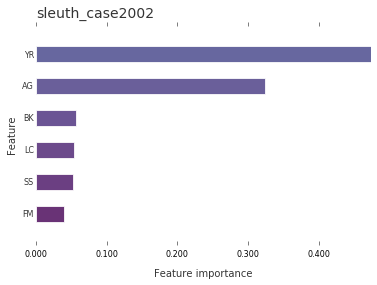

In [9]:
data = oml.datasets.get_dataset(dataset)
dataset_name, features, importances, indices = build_forest(data)
plot_feature_importances(features, importances, indices)

Plot of the regression baseline acuracy of the various baseline strategies using scikit-learn DummyRegressor.

The target feature is: **CD**

The $R^2$ statistic is calculated as a baseline.

The following baseline strategies are used: mean, median.

The strategies work as follow according to the sciki-learn API:

- **mean**: Always predicts the mean of the training set.

- **median**: Always predicts the median of the training set.

[More information.](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)


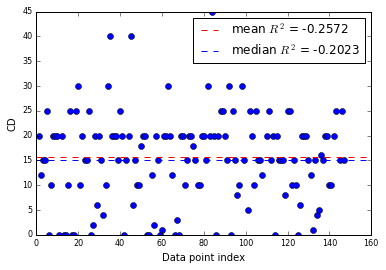

In [10]:
scores, y = regBaseline(data)
maxBaseline = plot_regBaseline(scores, y) 
strats = {} 

Runs the decision tree regressor algorithm with default hyperparameters using scikit-learn DecisionTreeRegressor.

[Explanation of how a decision tree works.](http://scikit-learn.org/stable/modules/tree.html)

The following hyperparameters have been added and can directly be changed in this notebook for further experimentation.
Their descriptions are according to the sciki-learn API:

- **criterion**:  string, optional (default=”mse”)

The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, and “mae” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node.

- **max_depth**: int or None, optional (default=None)

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- **min_samples_leaf**:  int, float, optional (default=1)

The minimum number of samples required to be at a leaf node:

- If int, then consider min_samples_leaf as the minimum number.
- If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.


- **max_features**: int, float, string or None, optional (default=None)

The number of features to consider when looking for the best split:

- If int, then consider max_features features at each split.
- If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
- If “auto”, then max_features=n_features.
- If “sqrt”, then max_features=sqrt(n_features).
- If “log2”, then max_features=log2(n_features).
- If None, then max_features=n_features.

Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

- **max_leaf_nodes**: int or None, optional (default=None)

Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

[More information and additional hyperparameters.](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)


In [11]:
#Runs the decision tree regressor algorithm on the dataset
from sklearn import tree
from sklearn.model_selection import KFold
#Running default values, it is recommended to experiment with the values of the parameters below. Try min_samples_leaf=5
clf = tree.DecisionTreeRegressor(criterion="mse", max_depth=None, min_samples_leaf=1, max_features=None, max_leaf_nodes=None)
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True);  
folds = 10
acc = 0

X = np.nan_to_num(X) 
y = np.nan_to_num(y)

p = len(features)
n = len(X)
#computational complexity O(n^2 * p)
complexity = n**2 * p

if complexity <= comp or comp == -1:
    for x in range(1,folds+1):
        if (n**2 * p * x) > comp and comp != -1:
            folds = x-1
            print("Number of folds would increase the complexity over the given threshold, number of folds has been set to: " + str(folds))
            break
    if folds > len(y):
        print("Number of folds are larger than number of samples, number of folds has been set to: " + str(len(y)))
        folds = len(y)
    kf = KFold(n_splits=folds) 
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        acc += clf.score(X_test, y_test)
    strats['decision tree'] = acc / folds
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the linear regression algorithm with default hyperparameters using scikit-learn LinearRegression.

[Explanation of how linear regression works.](http://scikit-learn.org/stable/modules/linear_model.html)

[More information.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


In [12]:
#Runs the linear regression algorithm on the dataset
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
#Running default values, it is recommended to experiment with the values of the parameters below. Try min_samples_leaf=5
clf = LinearRegression()
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
folds = 10
acc = 0

X = np.nan_to_num(X) 
y = np.nan_to_num(y)

p = len(features)
n = len(X)
#computational complexity O(p^2 *n + P^3)
complexity = p**2 * n + p**3

if complexity <= comp or comp == -1:
    for x in range(1,folds+1):
        if ((p**2 * n + p**3) * x) > comp and comp != -1:
            folds = x-1
            print("Number of folds would increase the complexity over the given threshold, number of folds has been set to: " + str(folds))
            break
    if folds > len(y):
        print("Number of folds are larger than number of samples, number of folds has been set to: " + str(len(y)))
        folds = len(y)
    kf = KFold(n_splits=folds) 
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        acc += clf.score(X_test, y_test)
    strats['linear regression'] = acc / folds
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the random forest regressor algorithm with default hyperparameters using scikit-learnRandomForestClassifierRandomForestRegressor.

[Explanation of how a random forest works.](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

The following hyperparameters have been added and can directly be changed in this notebook for further experimentation.
Their descriptions are according to the sciki-learn API:

- **n_estimators** : integer, optional (default=10)

The number of trees in the forest.

- **criterion**:  string, optional (default=”mse”)

The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error.

- **max_depth**: integer or None, optional (default=None)

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- **min_samples_leaf**:  int, float, optional (default=1)

The minimum number of samples required to be at a leaf node:

- If int, then consider min_samples_leaf as the minimum number.
- If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.


- **max_features**: int, float, string or None, optional (default=”auto”)

The number of features to consider when looking for the best split:

- If int, then consider max_features features at each split.
- If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
- If “auto”, then max_features=n_features.
- If “sqrt”, then max_features=sqrt(n_features).
- If “log2”, then max_features=log2(n_features).
- If None, then max_features=n_features.

Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

- **max_leaf_nodes**: int or None, optional (default=None)

Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

[More information and additional hyperparameters.](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [13]:
#Runs the random forest algorithm on the dataset.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
#Running default values, it is recommended to experiment with the values of the parameters below.
n_trees = 10 #Sets n_estimators such that the complexity value is calculated correctly.
clf = RandomForestRegressor(n_estimators=n_trees, criterion="mse", max_depth=None, min_samples_leaf=1, max_features=None, max_leaf_nodes=None)
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
folds = 10
acc = 0

X = np.nan_to_num(X) 
y = np.nan_to_num(y)

p = len(features)
n = len(X)
#computational complexity O(n^2 * p * n_trees)
complexity = n**2 * p * n_trees

if complexity <= comp or comp == -1:
    for x in range(1,folds+1):
        if (n**2 * p * n_trees) > comp and comp != -1:
            folds = x-1
            print("Number of folds would increase the complexity over the given threshold, number of folds has been set to: " + str(folds))
            break
    if folds > len(y):
        print("Number of folds are larger than number of samples, number of folds has been set to: " + str(len(y)))
        folds = len(y)
    kf = KFold(n_splits=folds) 
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        acc += clf.score(X_test, y_test)
    strats['random forest'] = acc / folds
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the regression support vector machine algorithm with default hyperparameters using scikit-learn SVR.

[Explanation of how a support vector machine works.](http://scikit-learn.org/stable/modules/svm.html)

The following hyperparameters have been added and can directly be changed in this notebook for further experimentation.
Their descriptions are according to the sciki-learn API:

- **C** : float, optional (default=1.0)

Penalty parameter C of the error term.

- **epsilon** : float, optional (default=0.1)

Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

- **kernel**:  string, optional (default=’rbf’)

Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to precompute the kernel matrix.

- **gamma**: float, optional (default=’auto’)

Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.

[More information and additional hyperparameters.](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)


In [14]:
#Runs the regression support vector machine algorithm on the dataset
from sklearn import svm
from sklearn.model_selection import KFold
#Running default values, it is recommended to experiment with the values of the parameters below.
clf = svm.SVR(C=1.0, epsilon=0.1, kernel="rbf", gamma="auto")
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
folds = 10
acc = 0

X = np.nan_to_num(X) 
y = np.nan_to_num(y)

p = len(features)
n = len(X)
#computational complexity O(n^2 * p + n^3)
complexity = n**2 * p + n**3

if complexity <= comp or comp == -1:
    for x in range(1,folds+1):
        if (((n**2 * p) + n**3) * x) > comp and comp != -1:
            folds = x-1
            print("Number of folds would increase the complexity over the given threshold, number of folds has been set to: " + str(folds))
            break
    if folds > len(y):
        print("Number of folds are larger than number of samples, number of folds has been set to: " + str(len(y)))
        folds = len(y)
    kf = KFold(n_splits=folds) 
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        acc += clf.score(X_test, y_test)
    strats['support vector machine'] = acc / folds
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the regression k-nearest neighbours algorithm with default hyperparameters using scikit-learn KNeighborsRegressor.

[Explanation of how k-nearest neighbours works.](http://scikit-learn.org/stable/modules/neighbors.html)

The following hyperparameters have been added and can directly be changed in this notebook for further experimentation.
Their descriptions are according to the sciki-learn API:

- **n_neighbors** : int, optional (default = 5)

Number of neighbors to use by default for kneighbors queries.

- **weights** : str or callable

weight function used in prediction. Possible values:

- ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

Uniform weights are used by default.

- algorithm : algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional

Algorithm used to compute the nearest neighbors:

- ‘ball_tree’ will use BallTree
- ‘kd_tree’ will use KDTree
- ‘brute’ will use a brute-force search.
- ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

Note: fitting on sparse input will override the setting of this parameter, using brute force.

[More information and additional hyperparameters.](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)


In [15]:
#Runs the regression k-nearest neighbours algorithm on the dataset
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
#Running default values, it is recommended to experiment with the values of the parameters below.
clf = KNeighborsRegressor(n_neighbors = 5, weights = "uniform", algorithm = "auto")
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
folds = 10
acc = 0

X = np.nan_to_num(X) 
y = np.nan_to_num(y)

p = len(features)
n = len(X)
#computational complexity O(n * p)
complexity = n * p 

if complexity <= comp or comp == -1:
    for x in range(1,folds+1):
        if (n * p * x) > comp and comp != -1:
            folds = x-1
            print("Number of folds would increase the complexity over the given threshold, number of folds has been set to: " + str(folds))
            break
    if folds > len(y):
        print("Number of folds are larger than number of samples, number of folds has been set to: " + str(len(y)))
        folds = len(y)
    kf = KFold(n_splits=folds) 
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        acc += clf.score(X_test, y_test)
    strats['k-nearest neighbours'] = acc / folds
else: 
    print("computation complexity too high, please run manually if desired.") 

Plot the accuracy of various machine learning algorithms against the baseline. 

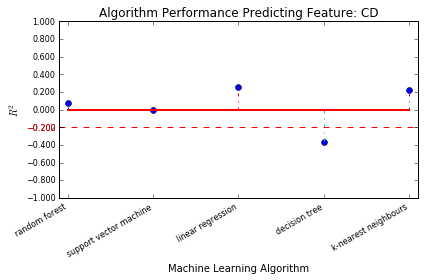

In [16]:
plot_alg(strats,maxBaseline) 